In [1]:
# for libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.graphics.regressionplots import *
from statsmodels.formula.api import ols
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, explained_variance_score, r2_score
from collections import OrderedDict

# Preparation

## Import Data

In [2]:
Ads = pd.read_csv('../data/Advertising.csv',index_col=0) # Using the first columns as index
Ads.head(5)

,TV,radio,newspaper,sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


## Data cleaning
- missing values?
- data type?

In [3]:
Ads.isna().sum()

TV           0
radio        0
newspaper    0
sales        0
dtype: int64

In [4]:
Ads.dtypes

TV           float64
radio        float64
newspaper    float64
sales        float64
dtype: object

In [5]:
y = Ads['sales']
tv = Ads['TV']
radio = Ads['radio']
news = Ads['newspaper']

# Simple Linear Regression

## Data Visualization

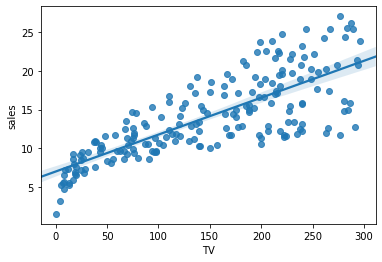

In [6]:
sns.regplot('TV', 'sales', data=Ads)

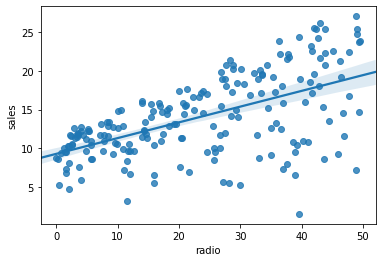

In [7]:
sns.regplot('radio', 'sales', data=Ads)

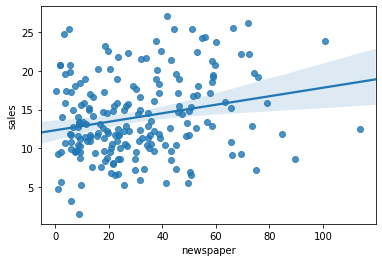

In [8]:
sns.regplot('newspaper', 'sales', data=Ads)

## Building models
Observing the scatterplot above, I choose to perform simple linear regression on sales~TV, because the linearity.

### sklearn 

In [9]:
model = linear_model.LinearRegression(fit_intercept=True) 
x = tv.values.reshape(-1, 1) # Need to reshape
model.fit(x,y)
model.intercept_, model.coef_

(7.032593549127693, array([0.04753664]))

In [10]:
y_pred = model.predict(x)
MSE = mean_squared_error(y, y_pred)
R_2 = r2_score(y, y_pred)
print(f'MSE is {MSE:.3f}, R^2 is {R_2:.3f}')

MSE is 10.513, R^2 is 0.612


### statsmodel
- ols (better printout form)
- R^2: always increases while involving more variables --> adjusted R^2

In [11]:
model = ols('sales~TV',Ads).fit()
model.summary()

/Users/zhouzihui/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     312.1
Date:                Tue, 14 Apr 2020   Prob (F-statistic):           1.47e-42
Time:                        23:13:51   Log-Likelihood:                -519.05
No. Observations:                 200   AIC:                             1042.
Df Residuals:                     198   BIC:                             1049.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.0326      0.458     15.360      0.000       6.130       7.935
TV             0.0475      0.003     17.668      0.000       0.042       0.053
==============================================================================
Omnibus:                        0.531   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.767   Jarque-Bera (JB):                0.669
Skew:                          -0.089   Prob(JB):                        0.716
Kurtosis:                       2.779   Cond. No.                         338.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### MSE value for furthur evaluation

In [12]:
y_pred = model.predict()
mean_squared_error(y, y_pred)

10.512652915656757

#### Confidence Interval

In [13]:
SE, iv_l, iv_u = wls_prediction_std(model)
pred_dict = OrderedDict({'x_train': tv,
                         'y_pred': y_pred, 
                         'y_true': y, 
                         'lower': iv_l, 
                         'upper': iv_u, 
                         'SE': SE})
pd.DataFrame(pred_dict)

,x_train,y_pred,y_true,lower,upper,SE
1,230.1,17.970775,22.1,11.513546,24.428003,3.274428
2,44.5,9.147974,10.4,2.682867,15.613081,3.278423
3,17.2,7.850224,9.3,1.371318,14.329129,3.285420
4,151.5,14.234395,18.5,7.792179,20.676611,3.266815
5,180.8,15.627218,12.9,9.182556,22.071880,3.268055
...,...,...,...,...,...,...
196,38.2,8.848493,7.6,2.380487,15.316500,3.279893
197,94.2,11.510545,9.7,5.062274,17.958816,3.269885
198,177.0,15.446579,12.8,9.002446,21.890712,3.267787
199,283.6,20.513985,25.5,14.031194,26.996776,3.287390


## Further plot analysis
- regression plot
- residual plot
- studentized residual plot high-leverage data (x outside of the normal range) 
- leverage plot: no high-leverage point in this situation

(-5, 5)

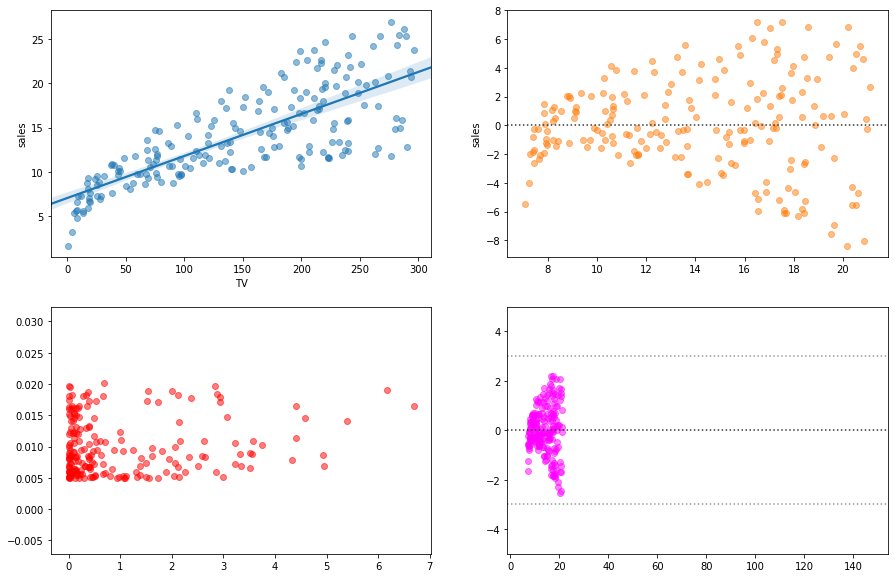

In [14]:
f, axes = plt.subplots(2, 2, sharex=False, sharey=False)
f.set_figheight(10)
f.set_figwidth(15)

# regression plot
sns.regplot('TV', 'sales', data=Ads, ax=axes[0, 0], scatter_kws={
            'alpha': '0.5'})

# residual plot
sns.residplot(y_pred, 'sales', data=Ads, ax=axes[0, 1], scatter_kws={
              'alpha': '0.5'})

# custom leverage plot instead of above
resid = model.resid
norm_resid = zscore(resid)
leverage = OLSInfluence(model).hat_matrix_diag
axes[1, 0].autoscale(enable=True, axis='y', tight=True)
axes[1, 0].scatter(norm_resid ** 2, leverage, alpha=0.5, color='red')

# studentized residual plot
resid_stud = resid/SE
axes[1, 1].scatter(y_pred, resid_stud, alpha=0.5, color='magenta')
axes[1, 1].axhline(0, ls=":", c=".2")
axes[1, 1].axhline(-3, ls=":", c=".6")
axes[1, 1].axhline(3, ls=":", c=".6")
axes[1, 1].set_ylim(-5, 5)

In [15]:
leverage.max() # seems fine

0.020208190219116698

# Multiple Linear Regression

Using smf statsmodel (ordinary least square)
- Residual plot
- correlation
- variable transformations
    - polynomial term
    - interaction terms
    - logarithm terms (right tail)
    - Categorical term
    - interaction term

## statsmodel

In [16]:
Ads.corr()

,TV,radio,newspaper,sales
TV,1.000000,0.054809,0.056648,0.782224
radio,0.054809,1.000000,0.354104,0.576223
newspaper,0.056648,0.354104,1.000000,0.228299
sales,0.782224,0.576223,0.228299,1.000000


In [17]:
model = ols('sales~TV+radio+newspaper',Ads).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     570.3
Date:                Tue, 14 Apr 2020   Prob (F-statistic):           1.58e-96
Time:                        23:13:53   Log-Likelihood:                -386.18
No. Observations:                 200   AIC:                             780.4
Df Residuals:                     196   BIC:                             793.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9389      0.312      9.422      0.000       2.324       3.554
TV             0.0458      0.001     32.809      0.000       0.043       0.049
radio          0.1885      0.009     21.893      0.000       0.172       0.206
newspaper     -0.0010      0.006     -0.177      0.860      -0.013       0.011
==============================================================================
Omnibus:                       60.414   Durbin-Watson:                   2.084
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              151.241
Skew:                          -1.327   Prob(JB):                     1.44e-33
Kurtosis:                       6.332   Cond. No.                         454.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Plot Analysis
### Residual plot
- it seems that there exists nonlinearity among the data

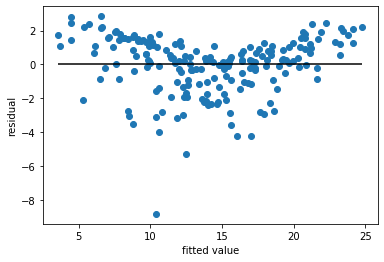

In [18]:
plt.scatter(model.predict(),model.resid.values) 
plt.xlabel("fitted value")
plt.ylabel("residual")
plt.hlines(0,xmin=np.min(model.predict()), xmax=np.max(model.predict()))
plt.show()

### Bar-plot--examining the right tails
- not obvious for the predictor and features

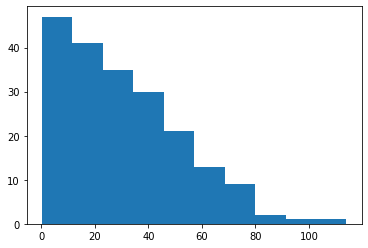

In [19]:
# Use histograms to explain why log transformation might help you solve the problem.
# Other plots behave as normal distribution
plt.hist(Ads["newspaper"].values)
plt.show()

### Pairplot
- strong linearity: sales~TV (also non-linearity)

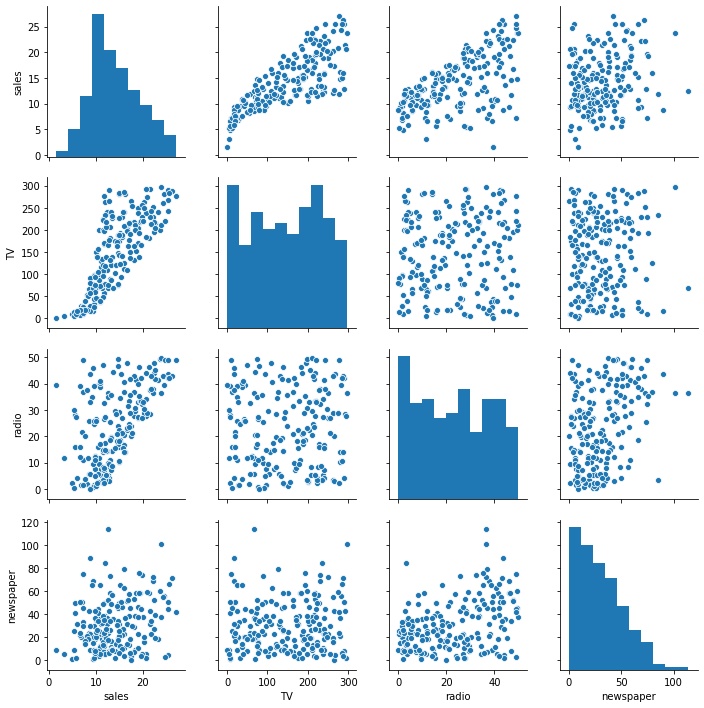

In [20]:
sns.pairplot(Ads[['sales','TV','radio','newspaper']])

### Furthur improvements
- multicollinearity(VIF): <br>
    - closer to 1: no-multicollinearity <br>
    - greater than 5/10: significant
- remove newspaper from predictors

In [21]:
est_TV = ols('sales~radio+newspaper', Ads).fit()
est_Radio = ols('sales~TV+newspaper', Ads).fit()
est_News = ols('sales~TV+radio', Ads).fit()

print(1/(1-est_TV .rsquared)) 
print(1/(1-est_Radio.rsquared))
print(1/(1-est_News.rsquared)) # Significant -- drop out newspaper (already do)

1.4985879943139764
2.823546636031611
9.727083434576869


## Improved model
- non-linearity
- interaction terms

In [22]:
model = ols('sales~TV+I(TV**2)+radio+TV:radio',Ads).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     3432.
Date:                Tue, 14 Apr 2020   Prob (F-statistic):          1.79e-179
Time:                        23:13:59   Log-Likelihood:                -186.86
No. Observations:                 200   AIC:                             383.7
Df Residuals:                     195   BIC:                             400.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.1371      0.193     26.663      0.000       4.757       5.517
TV             0.0509      0.002     22.810      0.000       0.047       0.055
I(TV ** 2)    -0.0001   6.89e-06    -15.920      0.000      -0.000   -9.61e-05
radio          0.0352      0.006      5.959      0.000       0.024       0.047
TV:radio       0.0011   3.47e-05     31.061      0.000       0.001       0.001
==============================================================================
Omnibus:                      169.759   Durbin-Watson:                   2.204
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4031.167
Skew:                          -2.988   Prob(JB):                         0.00
Kurtosis:                      24.166   Cond. No.                     1.70e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.7e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

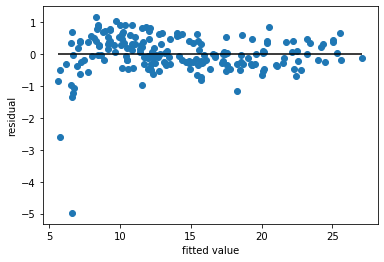

In [23]:
plt.scatter(model.predict(),model.resid.values) 
plt.xlabel("fitted value")
plt.ylabel("residual")
plt.hlines(0,xmin=np.min(model.predict()), xmax=np.max(model.predict()))
plt.show()

In [24]:
MSE = mean_squared_error(model.predict(),y)
print(f'The current MSE is {MSE:.5f} which is much lower than 10.513 (simple linear regression). ')

The current MSE is 0.37935 which is much lower than 10.513 (simple linear regression). 
